# Basurales: Entrenamiento

El objetivo de este proyecto es la detección de basurales a cielo abierto en la zona del AMBA. Para ello se utiliza un modelo de de machine learning de tipo CNN, dispuesto en una arquitectura denominada U-Net. Este esta especializado en la segmentacion de objetos.

Se exploraron dos 2 tipos de imágenes. Por un lado las imagenes RGB+NIR, provenientes del satélite Sentinel-2, y por otro las imagenes termicas (B10 y B11) del satelite Lansat-8. A su vez, se exploraron diferentes alternativas de información en las imágenes

* Imagen RGB + NIR
* Imagen RGB + NIR + Imagen termica Lansat 8

Esta información se añade en forma de una  banda extra en la imagen, de este modo pasan a ser de 4 bandas (RGB NIR) a 5 bandas. 

### Descarga de las imágenes  (vuelo)

In [ ]:
# !gsutil cp -r <PATH>

## Preprocesamiento


### Imágenes 4D Sentinel 2

El modelo entrena con un set de imagenes y mascaras binarias que delimitan el objeto de interes. 

Este set se generan vía **satproc_extract_chips**. Esta herramienta se utiliza tanto en la generación del dataset de entrenamiento como en el de predicción, en el primer caso se generan las imágenes y las máscaras, y en el segundo solo las imágenes.

Para generar las imágenes 4D del entrenamiento:

In [8]:
!ls ./../data/img/img_train_tmp/2021-01-01_2021-01-30/areas/

fid_0.tif   fid_21.tif	fid_34.tif  fid_47.tif	fid_6.tif   fid_72.tif
fid_1.tif   fid_22.tif	fid_35.tif  fid_48.tif	fid_60.tif  fid_73.tif
fid_10.tif  fid_23.tif	fid_36.tif  fid_49.tif	fid_61.tif  fid_74.tif
fid_11.tif  fid_24.tif	fid_37.tif  fid_5.tif	fid_62.tif  fid_75.tif
fid_12.tif  fid_25.tif	fid_38.tif  fid_50.tif	fid_63.tif  fid_76.tif
fid_13.tif  fid_26.tif	fid_39.tif  fid_51.tif	fid_64.tif  fid_77.tif
fid_14.tif  fid_27.tif	fid_4.tif   fid_52.tif	fid_65.tif  fid_78.tif
fid_15.tif  fid_28.tif	fid_40.tif  fid_53.tif	fid_66.tif  fid_79.tif
fid_16.tif  fid_29.tif	fid_41.tif  fid_54.tif	fid_67.tif  fid_8.tif
fid_17.tif  fid_3.tif	fid_42.tif  fid_55.tif	fid_68.tif  fid_9.tif
fid_18.tif  fid_30.tif	fid_43.tif  fid_56.tif	fid_69.tif
fid_19.tif  fid_31.tif	fid_44.tif  fid_57.tif	fid_7.tif
fid_2.tif   fid_32.tif	fid_45.tif  fid_58.tif	fid_70.tif
fid_20.tif  fid_33.tif	fid_46.tif  fid_59.tif	fid_71.tif


In [10]:
!ls ./../data/shp/gt/basura.shp

LINEA_DE_BASE_BASURALES.cst  basura.prj      basura_cov.shx
LINEA_DE_BASE_BASURALES.dbf  basura.shp      basurales_4326.gpkg
LINEA_DE_BASE_BASURALES.prj  basura.shx      basurales_4326.gpkg-shm
LINEA_DE_BASE_BASURALES.shp  basura_cov.cpg  basurales_4326.gpkg-wal
LINEA_DE_BASE_BASURALES.shx  basura_cov.dbf  puntos.geojson
basura.cpg		     basura_cov.prj
basura.dbf		     basura_cov.shp


In [11]:
!satproc_extract_chips \
     ./../data/img/img_train_tmp/2021-01-01_2021-01-30/areas/tiles_.tif \
    -o ./../data/data_train_4D/S2/160_100/ \
    --size 160 \
    --step-size 100 \
    --crs epsg:4326 \
    --aoi ./../data/shp/gt/basura.shp \
    --labels ./../data/shp/gt/basura.shp \
    --label-property 'class' \
    --classes 'B'
    

[2021-03-09 20:27:39] ERROR:fiona._env:Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.
[2021-03-09 20:27:39] ERROR:fiona._env:Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.
[2021-03-09 20:27:39] WARNING:satproc.chips:No features of class 'B' found. Will generate empty masks.
  0%|                                                     | 0/1 [00:17<?, ?it/s]
Traceback (most recent call last):
  File "rasterio/_crs.pyx", line 279, in rasterio._crs._CRS.from_epsg
  File "rasterio/_err.pyx", line 190, in rasterio._err.exc_wrap_int
rasterio._err.CPLE_OpenFailedError: Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.

During handling of the above exception, another exception occurred:

Traceback (most recent call la

In [10]:
!rm -rf ./../data/data_train_4D/S2/500_400


###### Donde los argumentos son:

* **El primer argumento** es la ruta a las imágenes 

* **o** es la ruta de destino 

Recomendamos que dicha ruta sea descriptiva, por ejemplo “data_train/600_600/Remesa08/ ” describe : Data_train → datos usados para entrenar; 400_400 → <tamaño de la imagen >_ <tamaño del step-size> (las imágenes son cuadradas); Remesa08 → Remesa sobre la que vamos a trabajar

* **size** tamaño de las imágenes resultantes (las imágenes son cuadradas) 
* **step-size** paso del proceso. Si *step-size* es igual que el *size* entonces no hay overlap en las imágenes. 

En ocaciones es útil para el entrenamiento generar los chips con un overlap de este modo tenemos más datos para entrenar. Pero en la predicción valor debe ser igual al tamaño que la imagen 

* **crs** epsg: le asigna un epsg a la imagen 

* **label-property** nombre del campo donde se define cada categoría (solo se usa para el entrenamiento) 

* **classes** nombres de las clases (como aparecen en el geojson), separados por espacios

* **aoi** ruta al archivo vectorial donde están definidas las localidades. Al definir una region de interés solo se procesan las imágenes que interceptan esas localidades.

Este comando va a generar dos carpetas en la ruta de destino : “images” y “masks”. Los archivos de la primera van a ser de tipo Tiff de 3 bandas (rgb) y los de la segunda van a ser, también, de tipo Tiff pero de N bandas donde N representa el número de clases, en este caso 4. Y donde cada una de las bandas es una máscara binaria


### Imágenes 5D

![](img/4D.png)

Como mencionamos anteriormente, tambien es necesario generar los datos de entrenamiento con las imagenes 4D (y 5D) ya que cada modelo es independiente. 

In [ ]:
#from meduy.postprocess.concatenate import concatenate

#input_dir  = 'data/data_train_3D/vuelo/600_600/images/'
#output_dir = 'data/data_train_4D/vuelo/600_600/images/'
#band_path  = 'data/4D_vuelo/parcelas_remesas/parcelas_remesa_1.tif'  ###

#concatenate(input_dir=input_dir,output_dir= output_dir, band_path=band_path)


Además debemos copiar las máscaras.

In [ ]:
#!os.makedirs('data/data_train_4D/vuelo/600_600/masks/', exist_ok=True)
#!cp /home/ro/meduy-mda/data/data_train_3D/vuelo/600_600/masks/* /home/ro/meduy-mda/data/data_train_4D/vuelo/600_600/masks/ 

## Entrenamiento  

### Entrenamiento 4D Sentinel-2

Las librerías que importamos nos permite acceder a las herramientas que vamos a utilizar a lo largo del proyecto como por ejemplo la función de train y predict  del modelo de Unet.

In [1]:
from basurales.unet.train import TrainConfig, train
from basurales.unet.evaluate import plot_data_generator
import os

/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/

En esta etapa debemos definir la configuración del modelo de ML


In [4]:
config_s2 = TrainConfig(width=160,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc)
                     height=160,
                     n_channels=4,  #  número de canales de la imagen, rgb -> 3
                     n_classes=1, # número de clases a clasificar
                     apply_image_augmentation=True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes 
                     seed=42,
                     epochs=15, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size=32, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch=200, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience=3, # a medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split=0.2, # se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento
                     images_path=os.path.join('./../data/data_train_4D','S2', '500_400'), #ruta a las imágenes
                     model_path=os.path.join('./../weights/', 'UNet_basurales_4D_500_400_spe200.h5')) #  ruta al archivo de entrenamiento

Podemos visualizar alguna de las imágenes y máscaras.

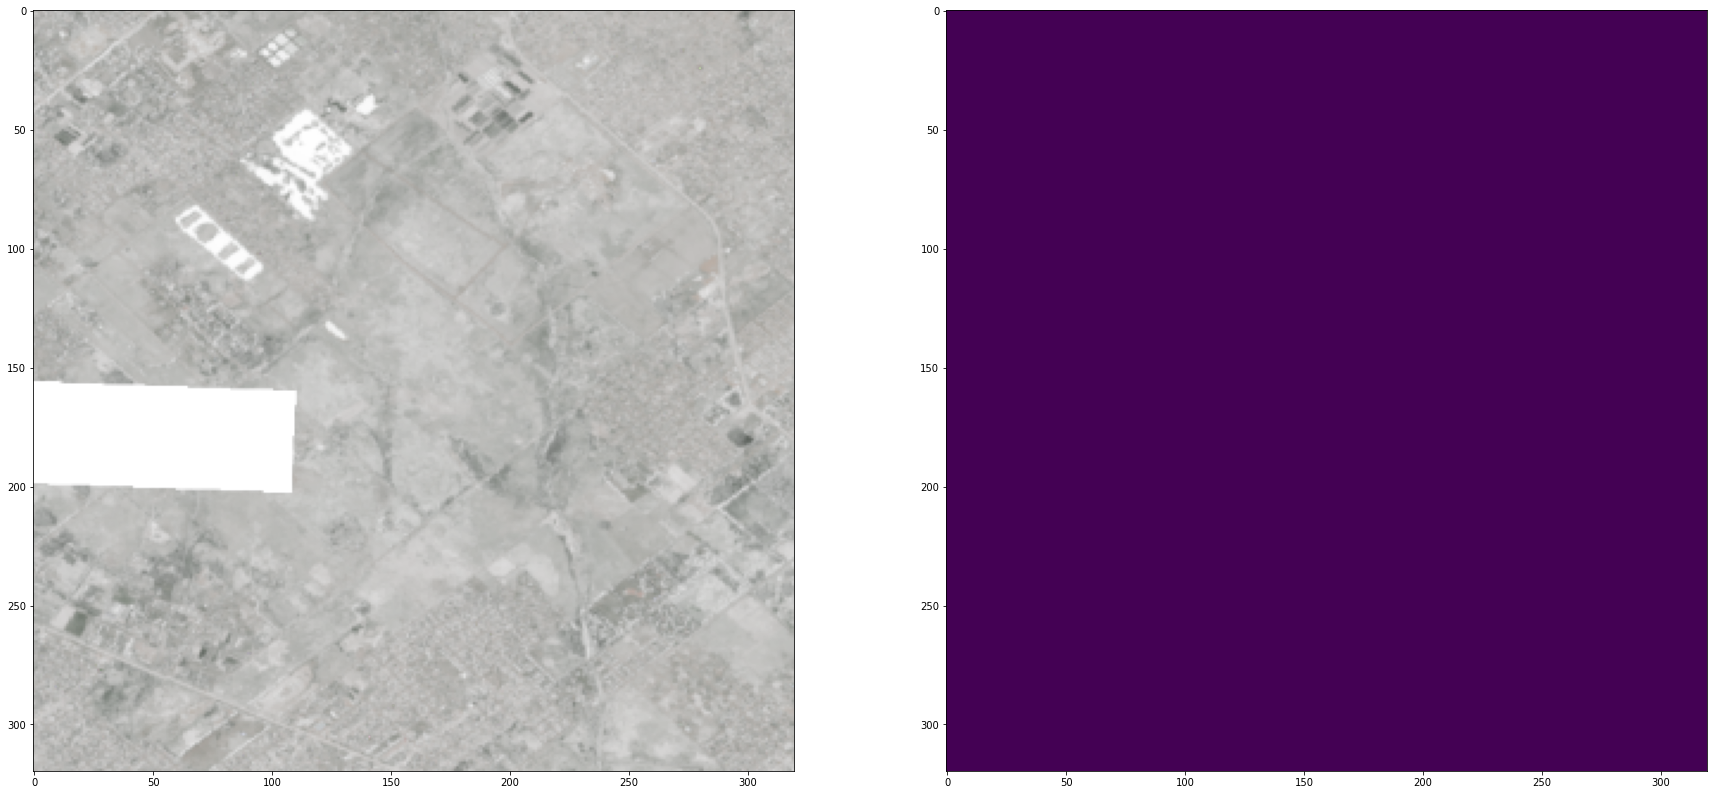

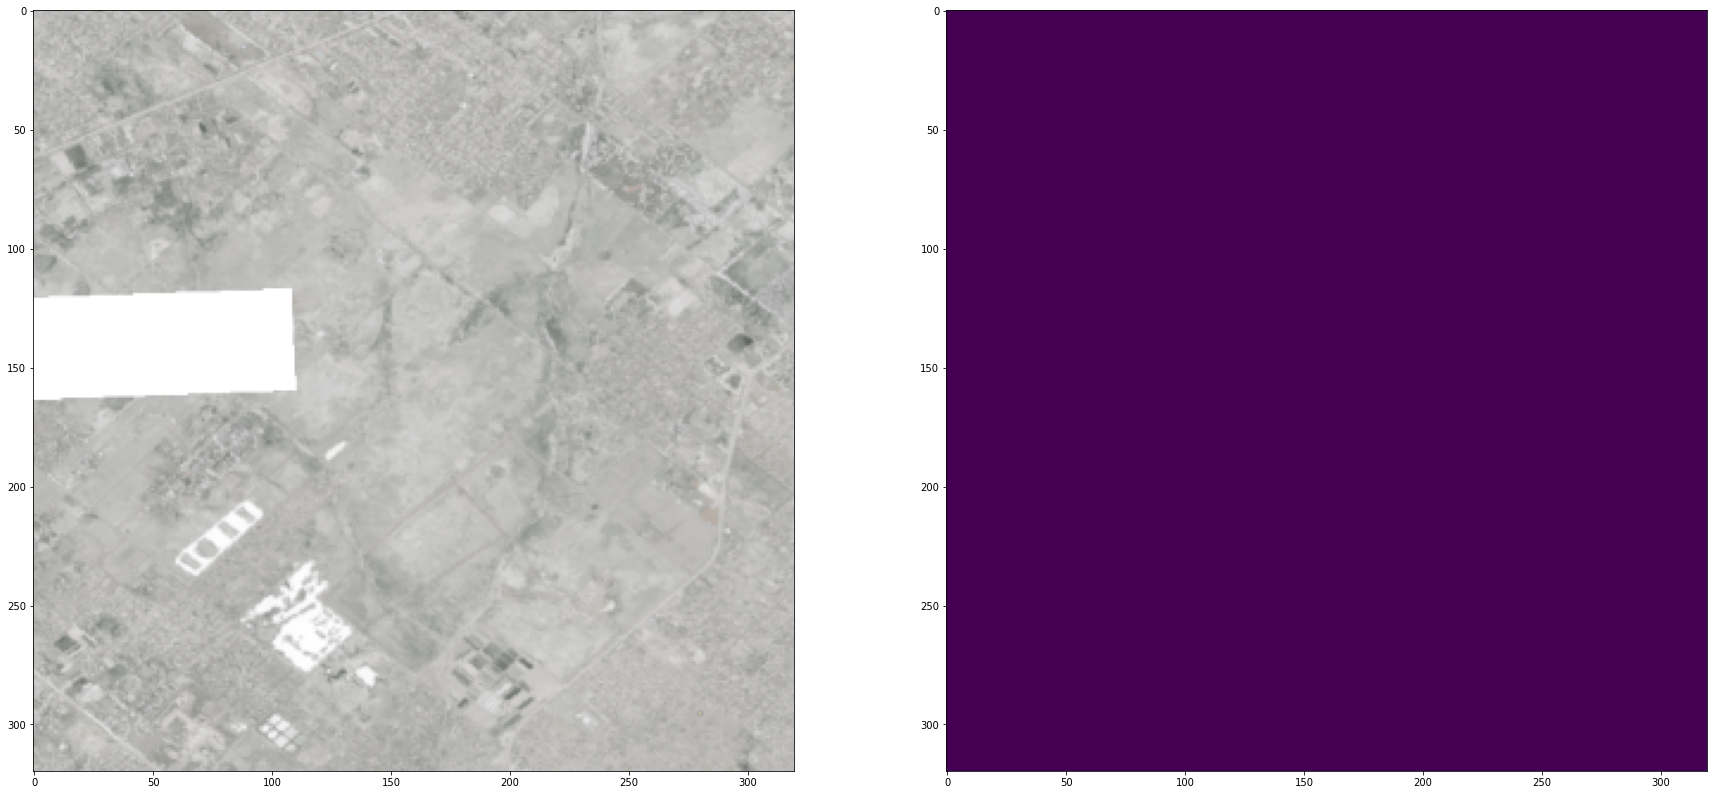

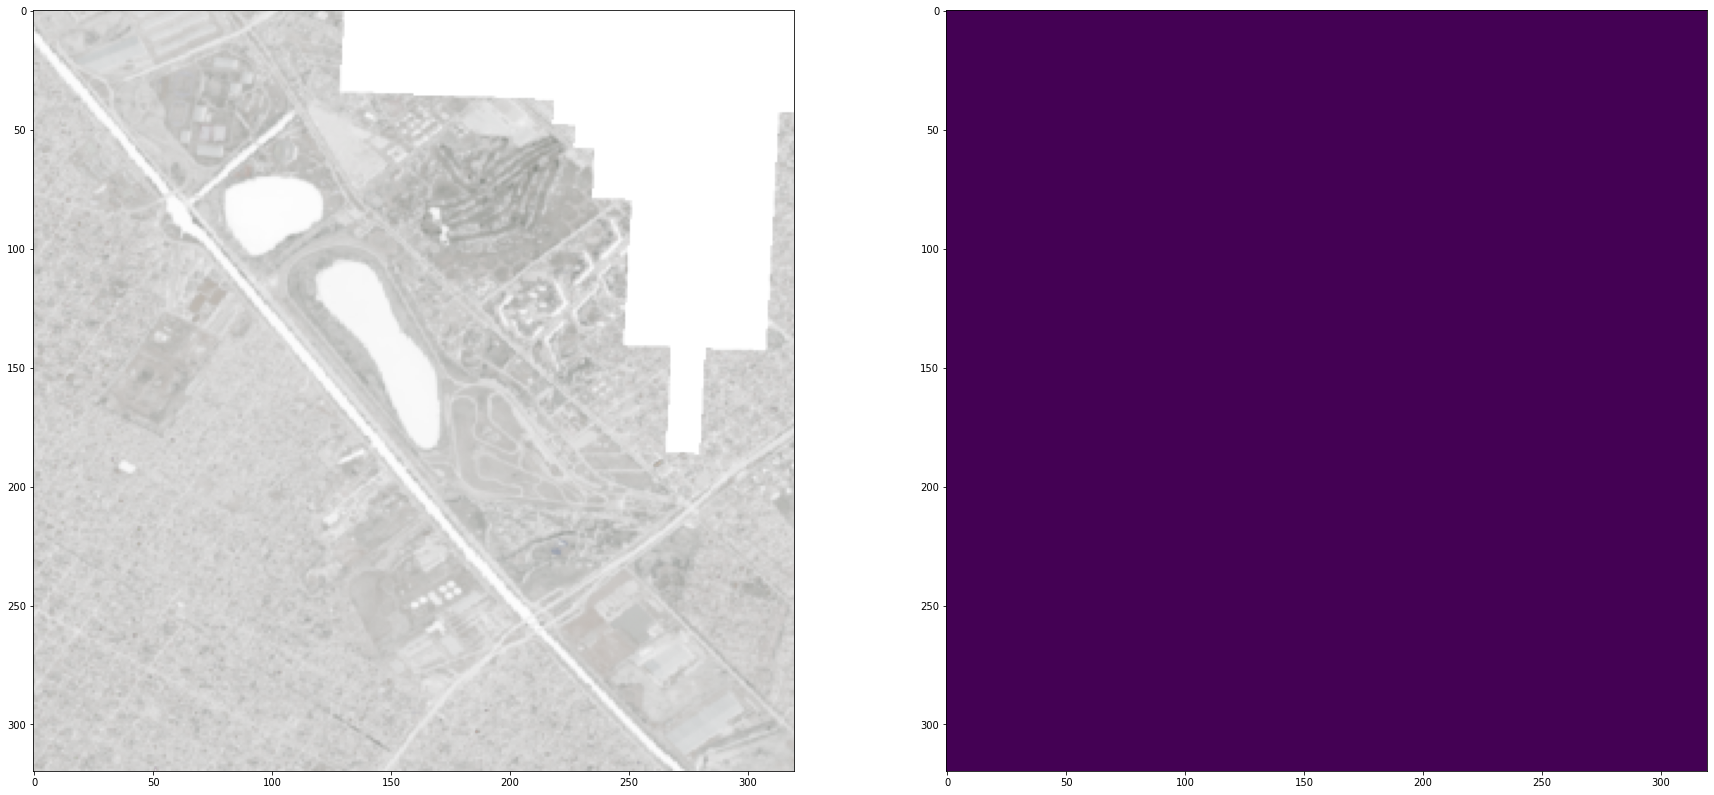

In [5]:
plot_data_generator(train_config=config_s2, num_samples=3, fig_size=(30,20))

Ejecuta el entrenamiento.

In [20]:
res_config_s2 = train(config_s2)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 320, 320, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 320, 320, 32) 9248        conv2d_162[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 160, 160, 32) 0           conv2d_163[0][0]                 
____________________________________________________________________________________________

In [ ]:
 import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_config_s2.history['loss'])
plt.plot(res_config_s2.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_config_s2.history['mean_iou'])
plt.plot(res_config_s2.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

### Entrenamiento - 5D

In [1]:
from meduy.unet.train import TrainConfig, train
from meduy.unet.evaluate import plot_data_generator
import os

/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-pack

In [6]:
config_4D = TrainConfig(width=320,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc)
                     height=320,
                     n_channels=4, ### #  número de canales de la imagen, rgb -> 3
                     n_classes=1, # número de clases a clasificar
                     apply_image_augmentation=True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes 
                     seed=42,
                     epochs=15, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size=32, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch=200, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience=3, # a medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split=0.2, # se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento
                     images_path=os.path.join('./data/data_train/','vuelo','4D', '600_600'),### #ruta a las imágenes
                     model_path=os.path.join('./weights/', 'UNet_asentamientos_4D_600-600_spe200.h5')) #  ruta al archivo de entrenamiento

In [7]:
res_4D_vuelo = train(config_4D)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 320, 320, 4)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 320, 320, 32) 1184        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 320, 320, 32) 9248        conv2d_47[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 160, 160, 32) 0           conv2d_48[0][0]                  
____________________________________________________________________________________________

RuntimeError: Your generator is NOT thread-safe.Keras requires a thread-safe generator when`use_multiprocessing=False, workers > 1`.For more information see issue #1638.

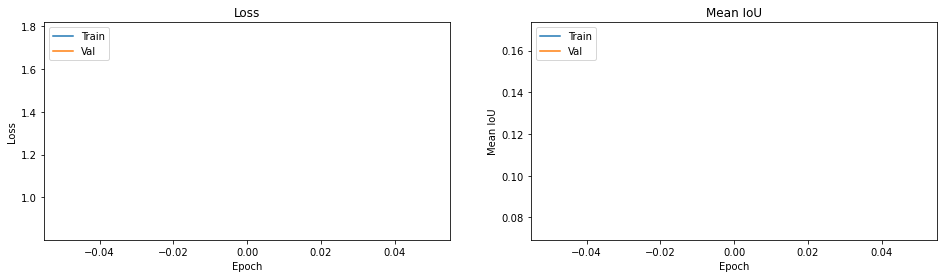

In [8]:
 import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_4D_vuelo.history['loss'])
plt.plot(res_4D_vuelo.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_4D_vuelo.history['mean_iou'])
plt.plot(res_4D_vuelo.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()